## SINGLE NEURON SYSTEM ##

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import itertools as it

In [35]:
def alpha_m(v): return np.where(np.abs(25 - v) < 1e-9, 1.0, (0.1 * (25 - v)) / (np.exp(np.clip((25 - v) / 10, -700, 700)) - 1))
def alpha_h(v): return 0.07 * np.exp(np.clip(-v / 20, -700, 700))
def alpha_n(v): return np.where(np.abs(10 - v) < 1e-9, 0.1, (0.01 * (10 - v)) / (np.exp(np.clip((10 - v) / 10, -700, 700)) - 1))

def beta_m(v): return 4 * np.exp(np.clip(-v / 18, -700, 700))
def beta_h(v): return 1 / (1 + np.exp(np.clip((30 - v) / 10, -700, 700)))
def beta_n(v): return 0.125 * np.exp(np.clip(-v / 80, -700, 700))

def m_inf(V): return alpha_m(V) / (alpha_m(V) + beta_m(V))
def h_inf(V): return alpha_h(V) / (alpha_h(V) + beta_h(V))
def n_inf(V): return alpha_n(V) / (alpha_n(V) + beta_n(V))

def I_Na(V,m,h,g_Na,E_Na): return g_Na * m**3 * h * (V - E_Na)
def I_K(V,n,g_K,E_K): return g_K * n**4 * (V - E_K)
def I_L(V,g_L,E_L): return g_L * (V - E_L)

def Id(t,Ie):
   return sum(valore * (t_start <= t < t_start + durata) for valore, t_start, durata in Ie)

def neuron(t,y,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie):
    V,m,h,n= y
    dV_dt = (Id(t,Ie)-I_Na(V,m,h,Gna,Vna)-I_K(V,n,Gk,Vk)-I_L(V,Gl,Vl))/Cm
    dm_dt = alpha_m(V)*(1-m)-beta_m(V)*m
    dh_dt = alpha_h(V)*(1-h)-beta_h(V)*h
    dn_dt = alpha_n(V)*(1-n)-beta_n(V)*n
    
    return [dV_dt, dm_dt, dh_dt, dn_dt]


def system_simulator(V0,T,n_p,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie):
    t_span = (0,T)
    t_eval = np.linspace(0,T,n_p)

    m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))
    h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))
    n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))

    y0 = [V0,m0,h0,n0]

    return solve_ivp(neuron, t_span, y0, args=(Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie),t_eval = t_eval)

def find_equilibrium_points(V0, Cm, Gna, Gk, Gl, Vna, Vk, Vl, Iext):
    def equilibrium(y, Cm, Gna, Gk, Gl, Vna, Vk, Vl, Ie):
        V, m, h, n = y
        dV_dt = (Ie - I_Na(V, m, h, Gna, Vna) - I_K(V, n, Gk, Vk) - I_L(V, Gl, Vl)) / Cm
        dm_dt = alpha_m(V) * (1 - m) - beta_m(V) * m
        dh_dt = alpha_h(V) * (1 - h) - beta_h(V) * h
        dn_dt = alpha_n(V) * (1 - n) - beta_n(V) * n
        return [dV_dt, dm_dt, dh_dt, dn_dt]

    m0 = []
    h0 = []
    n0 = []

    for v in V0:
        m0.append(alpha_m(v) / (alpha_m(v) + beta_m(v)))
        h0.append(alpha_h(v) / (alpha_h(v) + beta_h(v)))
        n0.append(alpha_n(v) / (alpha_n(v) + beta_n(v)))
    start_points = list(zip(V0,m0,h0,n0))
    eqs_point = set()
    
    for point in start_points:
        sol, infodict, ier, msg = fsolve(equilibrium, x0=point, args=(Cm, Gna, Gk, Gl, Vna, Vk, Vl, Iext), full_output=True)
        if ier == 1:  #controllo sulla convergenza
            eqs_point.add(tuple(np.round(sol, decimals=4), ))  # Evita duplicati numerici
        else:
            print(f"Non convergente per il punto iniziale: {point}, messaggio: {msg}")
    
    eqs_point = sorted(eqs_point, key=lambda x: x[0])  
    return eqs_point


In [3]:


def time_plots(T,n_p,V0,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie):
    sol = system_simulator(V0,T,n_p,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie)
    V = sol.y[0]
    m = sol.y[1]
    h = sol.y[2]
    n = sol.y[3]
    t = sol.t

    plt.figure(figsize=(20,10))
    #grafico del potenziale nel tempo
    plt.subplot(1,2,1)
    plt.plot(t, V)
    plt.xlabel('Tempo (ms)')
    plt.ylabel('Potenziale di membrana (mV)')
    plt.title('Potenziale nel tempo')
    plt.grid(True)
    #grafico delle probabilità di apertura nel tempo
    plt.subplot(1,2,2)
    plt.plot(t, m, label = 'm ratio', color = 'red')
    plt.plot(t, h, label = 'h ratio', color = 'blue')
    plt.plot(t, n, label = 'n ratio', color = 'green')
    plt.xlabel('Tempo (ms)')
    plt.ylabel('P di apertura dei canali')
    plt.title('Probabilità di apertura nel tempo')
    plt.legend()
    plt.grid(True)

def phase_plots(T,n_p,V0,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie):
    sol = system_simulator(V0,T,n_p,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie)
    V = sol.y[0]
    m = sol.y[1]
    h = sol.y[2]
    n = sol.y[3]

    plt.figure(figsize=(21,7))
    #potenziale vs sodium gate
    plt.subplot(1,2,1)
    plt.plot(m,V, label = 'm ratio', color = 'red')
    plt.plot(h,V, label = 'h ration', color = 'blue')
    plt.xlabel('P apertura canali di sodio')
    plt.ylabel('Potenziale di membrana (mV)')
    plt.title('Potenziale vs Sodio')
    plt.legend()
    plt.grid(True)

    #potenziale vs potassium gate
    plt.subplot(1,2,2)
    plt.plot(n,V)
    plt.xlabel('P apertura canali di potassio')
    plt.ylabel('Potenziale di membrana (mV)')
    plt.title('Potenziale vs Potassio')
    plt.grid(True)

def plot_equilibria(equilibria):
    equilibria = np.array(equilibria)  # Converte la lista di tuple in array per manipolazione
    V = equilibria[:, 0]
    m = equilibria[:, 1]
    h = equilibria[:, 2]
    n = equilibria[:, 3]

    plt.figure(figsize=(10, 6))

    # Plot per ciascuna variabile
    plt.plot(V, m, label='m (attivazione Na)', marker='o', linestyle='--')
    plt.plot(V, h, label='h (inattivazione Na)', marker='s', linestyle='-.')
    plt.plot(V, n, label='n (attivazione K)', marker='^', linestyle=':')

    plt.xlabel("Potenziale di membrana (V) [mV]")
    plt.ylabel("Variabili di gating")
    plt.title("Punti di equilibrio: Potenziale di membrana vs Variabili di gating")
    plt.legend()
    plt.grid()
    plt.show()





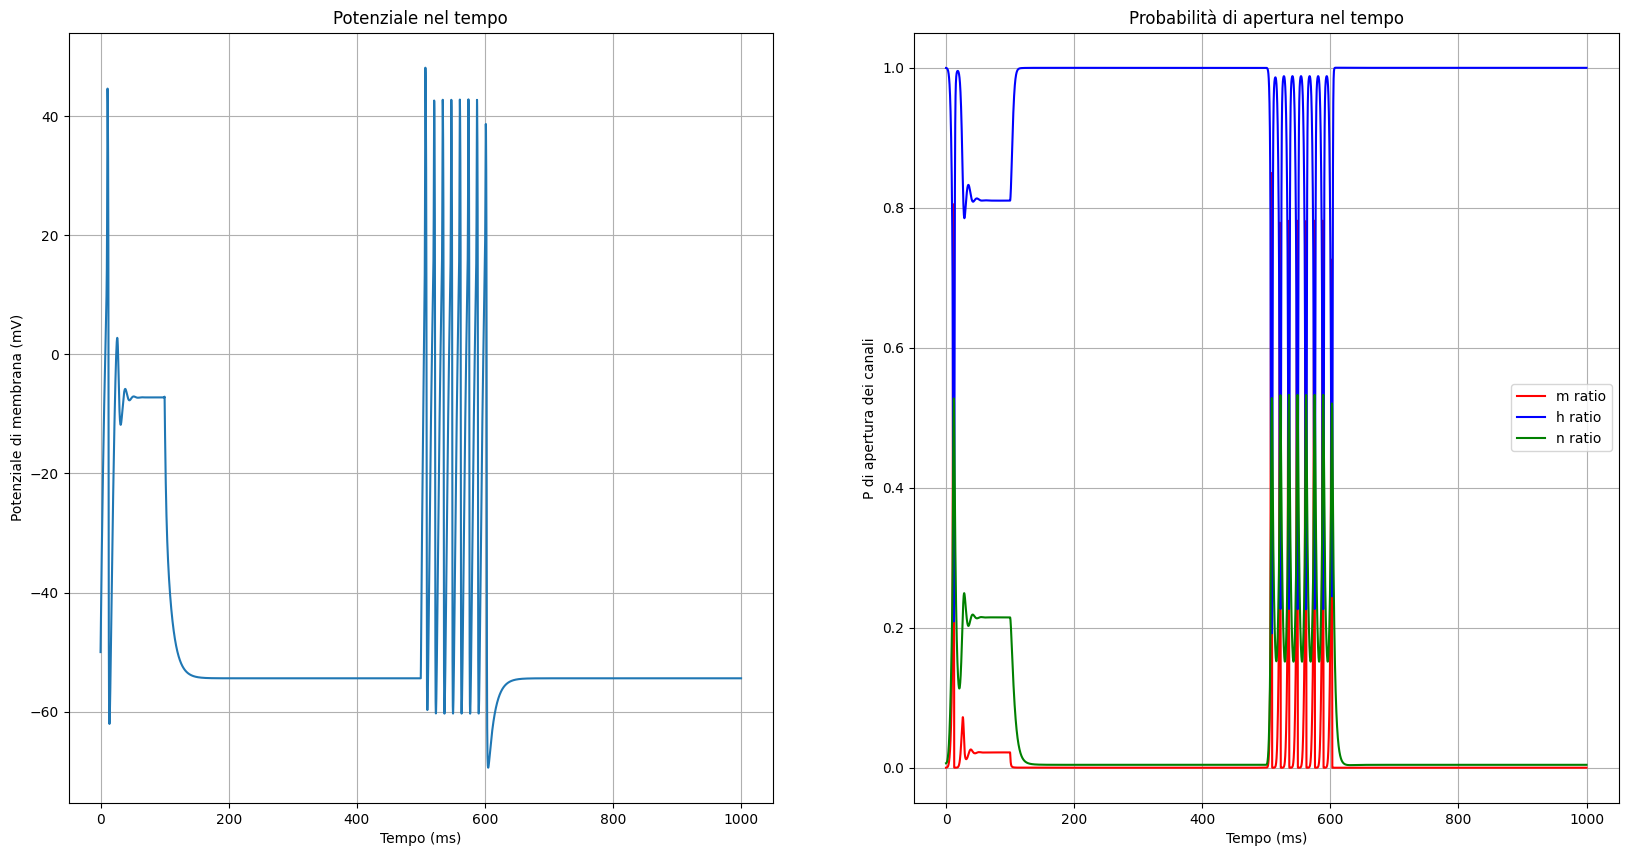

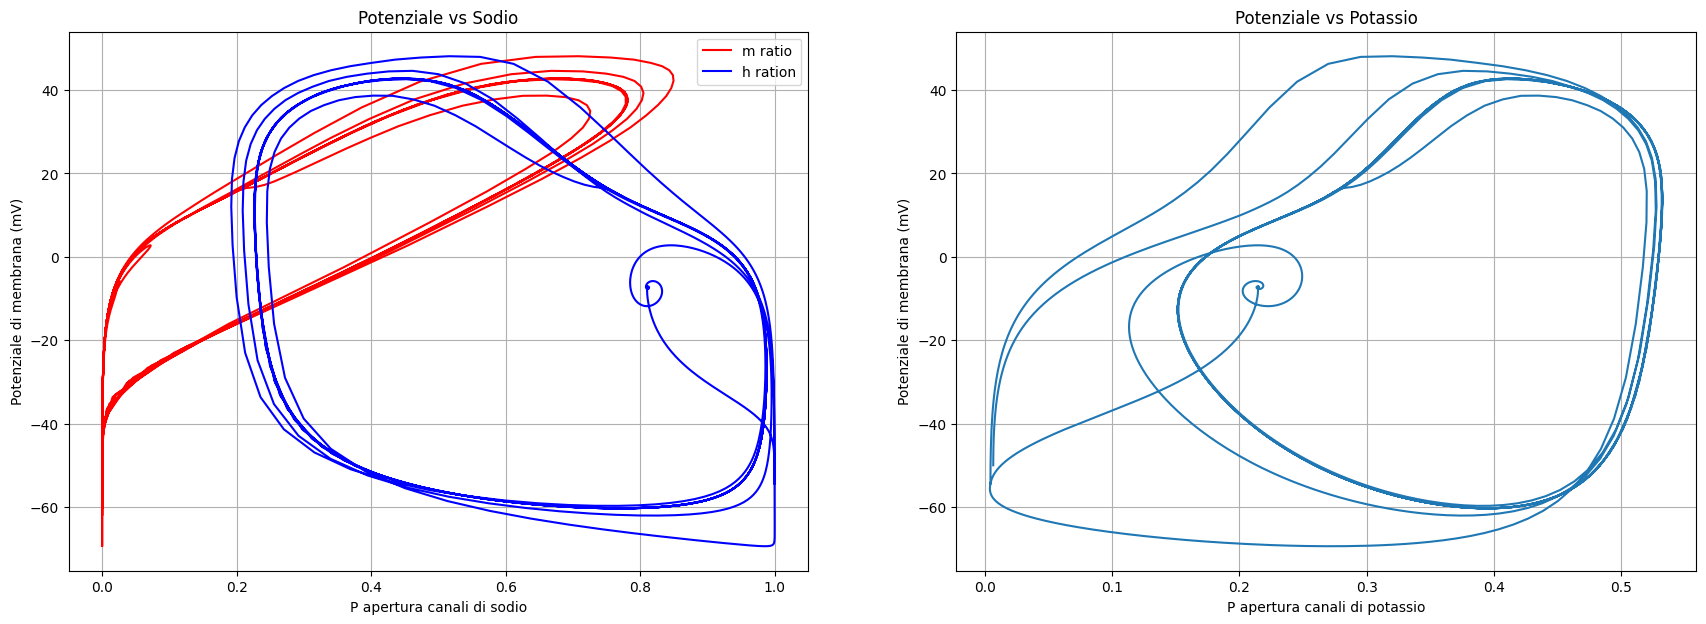

In [38]:
Cm = 1
Gna = 120
Gk = 36
Gl = 0.1
Vna = 50
Vk = -77
Vl = -54.4
Ie = [(10,0,100), (14,500,100)]
V0 = -50.0
T = 1000
n_p = 10000

time_plots(1000,n_p,V0,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie)
phase_plots(T,n_p,V0,Cm,Gna,Gk,Gl,Vna,Vk,Vl,Ie)

In [24]:
# Intervalli iniziali
V_start = [-90,-70,-65,-60,-55,-50,0,50]

# Parametri
Cm = 1
Gna = 120
Gk = 36
Gl = 0.1
Vna = 50
Vk = -77
Vl = -54.4
Iext = 14

# Trova i punti di equilibrio
equilibria = find_equilibrium_points(V_start, Cm, Gna, Gk, Gl, Vna, Vk, Vl, Iext)
print("Punti di equilibrio trovati:")
for eq in equilibria:
    print(eq)


Punti di equilibrio trovati:
(np.float64(-5.0422), np.float64(0.0288), np.float64(0.7552), np.float64(0.244))


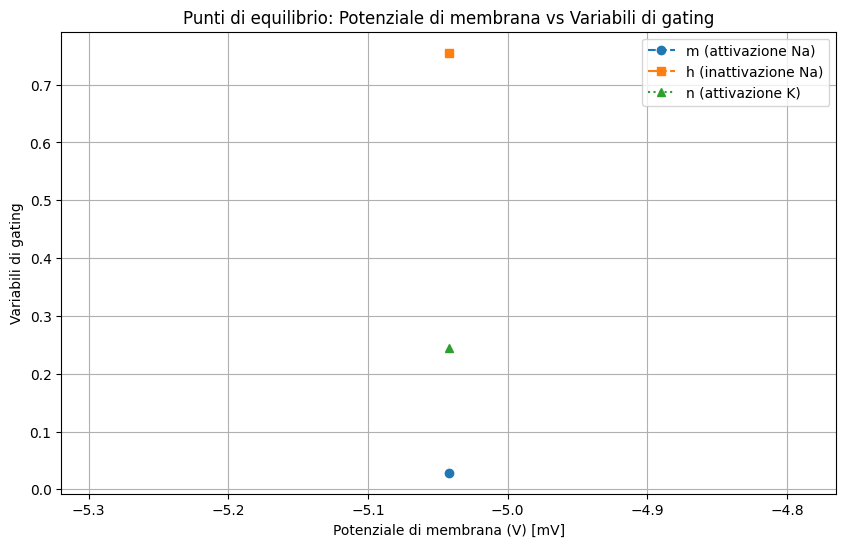

In [25]:

plot_equilibria(equilibria)


In [ ]:
Gk = 36.0
Gna = 120.0
Gl = 0.3
Cm = 1.0
Vk = -12.0
Vna = 115.0
Vl = 10.613
V0 = 0.0
Ie = [(10,0,100), (6,300,100)]


Cm = 1.0
Gna = 120.0
Gk = 36.0
Gl = 0.1
Vna = 50.0
Vk = -77.0
Vl = -54.4
V0 = -65
Ie = [(10, 100, 50), (-5, 200, 50), (15, 300, 100), (-10, 400, 50)]